(quimb-within-torch)=

# Using `quimb` within `torch`

`quimb` is designed (using [`autoray`](https://github.com/jcmgray/autoray)) to
handle many different array backends, including [`torch`](https://github.com/google/jax). If you put `torch` arrays in your tensors, then `quimb` will dispatch all operations to `torch` functions, and moreover tensor network algorithms can then be traced through in order to compute gradients, and/or jit-compiled.

While quimb has its own optimizer interface (`TNOptimizer`) which uses `torch`
or other libraries within it to compute the gradients, it is also possible to instead use `quimb` *within other* optimization frameworks. Here we demonstrate this for the standard `torch`
optimization interface.

Here'll we do a simple 1D MERA optimization on the Heisenberg model:

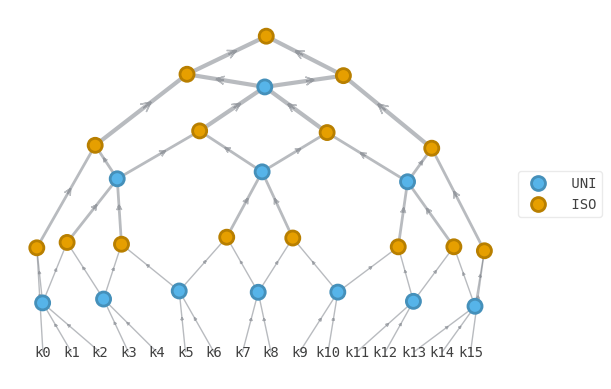

In [1]:
import quimb.tensor as qtn
from quimb.experimental.merabuilder import MERA

# our ansatz and hamiltonian
L = 16
psi = MERA.rand(L, D=8, seed=42, cyclic=False)
ham = qtn.ham_1d_heis(L)

psi.draw(
    color=['UNI', 'ISO'],
    fix={psi.site_ind(i): (i, 0) for i in range(L)},
)

As with `TNOptimizer`, we need a `loss_fn` which takes a tensor network and returns a scalar quantity to minimize. Often we also need a `norm_fn`, which first maps the tensor network into a constrained space (for example, with all unitary tensors):

In [2]:
def norm_fn(psi):
    # parametrize our tensors as isometric/unitary
    return psi.isometrize(method="cayley")

def loss_fn(psi):
    # compute the total energy, here quimb handles constructing
    # and contracting all the appropriate lightcones
    return psi.compute_local_expectation(ham)

In [3]:
# our initial energy:
loss_fn(norm_fn(psi))

-0.015578916803187327

The we are ready to construct our model using `torch`:

In [4]:
import torch

psi.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))
ham.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))


class TNModel(torch.nn.Module):

    def __init__(self, tn):
        super().__init__()
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(tn)
        # n.b. you might want to do extra processing here to e.g. store each
        # parameter as a reshaped matrix (from left_inds -> right_inds), for
        # some optimizers, and for some torch parametrizations
        self.torch_params = torch.nn.ParameterDict({
            # torch requires strings as keys
            str(i): torch.nn.Parameter(initial)
            for i, initial in params.items()
        })

    def forward(self):
        # convert back to original int key format
        params = {int(i): p for i, p in self.torch_params.items()}
        # reconstruct the TN with the new parameters
        psi = qtn.unpack(params, self.skeleton)
        # isometrize and then return the energy
        return loss_fn(norm_fn(psi))

Construct and test the initial energy of our model:

In [5]:
model = TNModel(psi)
model()

tensor(0.0759, grad_fn=<AddBackward0>)

Optionally we can jit-compile the model for faster execution:

In [6]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings(
        action='ignore',
        message='.*trace might not generalize.*',
    )
    model = torch.jit.trace_module(model, {"forward": []})

The we define an optimizer, here we use one from the package
[`torch_optimizer`](https://github.com/jettify/pytorch-optimizer),
but it could simply be from `torch.optim` as well.

In [7]:
import torch_optimizer

optimizer = torch_optimizer.AdaBelief(model.parameters(), lr=0.01)

And now we are ready to optimize!

In [8]:
import tqdm

its = 1_000
pbar = tqdm.tqdm(range(its))

for _ in pbar:
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss}")

-6.891433238983154: 100%|██████████| 1000/1000 [00:33<00:00, 29.78it/s]


Finally if we want to insert the optimized raw parameters back into a tensor network then we can do so with:

In [9]:
mera_opt = psi.copy()
params = {
    int(i): model.torch_params.get_parameter(str(i)).detach()
    for i in mera_opt.get_params()
}
mera_opt.set_params(params)

# then we want the constrained form
mera_opt = norm_fn(mera_opt)

Then we can check the energy outside of torch:

In [10]:
# convert back to numpy
mera_opt.apply_to_arrays(lambda x: x.numpy())
ham.apply_to_arrays(lambda x: x.numpy())

# compute the energy
loss_fn(mera_opt)

-6.8914468586444855

and that the state is still unitary and thus normalized:

In [11]:
mera_opt.H @ mera_opt

1.0000001